In [139]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
import numpy
import sys
from scipy import stats

restaurants = pd.read_csv('final_restaurants.csv')

In [158]:
contingency = list()
for code in restaurants['postal code'].unique():
    chains = restaurants[restaurants['postal code']==code]['is chain'].sum()
    indie = restaurants[restaurants['postal code']==code]['is chain'].count() - chains
    if chains != 0 and indie != 0:
        contingency.append([indie, chains])
chi2res = stats.chi2_contingency(contingency)
chi2res[1]
# extremely small p-value, reject that values are independent across categories.

4.839253212814388e-39

Trying to do ANOVA... but I dont think the data is fit for that...

In [118]:
restaurants = restaurants[['name','amenity','tags','postal code','is chain']]
grouped = restaurants.groupby('postal code', as_index=False).agg({'is chain': ['sum', 'count']})
grouped.columns = grouped.columns.map('_'.join)
grouped = grouped.reset_index(drop=True)
grouped['mean'] = grouped['is chain_sum'] / grouped['is chain_count']
grouped = grouped[['postal code_','mean']]
grouped

,postal code_,mean
0,J4Y,0.000000
1,L6A,0.000000
2,V0M,0.000000
3,V0N,0.000000
4,V1M,0.396825
...,...,...
99,V7T,0.560000
100,V7V,0.235294
101,V7W,0.350000
102,V7X,0.666667


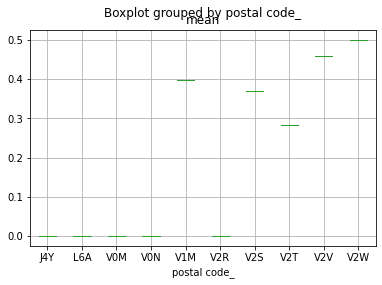

In [69]:
grouped[0:10].boxplot(column='mean', by='postal code_')

In [32]:
formula = "restaurants['is chain'] ~ restaurants['postal code']"
lm = ols(restaurants['is chain'] ~ restaurants['postal code'], restaurants).fit()
print(lm.summary())

SyntaxError: invalid syntax (<ipython-input-32-b4591272a102>, line 2)